In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
plt.style.use('ggplot')
import seaborn as sns
from enum import Enum
import matplotlib.colors as mcolors    
import colorsys

In [15]:
results2 = pd.read_csv("../test_results/hyper_sdqlpy_optimisations_v2_pandas_tpch_test_results.csv") 
#results2 = results2.rename(columns={"Average": "Mean"})

results2 = results2[results2["Query Name"].isin(["SDQLpy Converted + PipelineBreakers NRP (Hyper DB)", "SDQLpy Converted + Both NRP (Hyper DB)"])]

In [16]:
results = pd.read_csv("../test_results/quick_hyper_sdqlpy_optimisations_pandas_tpch_test_results.csv") 

results = pd.concat([results, results2], ignore_index=True)
#results = results.rename(columns={"Average": "Mean"})

In [17]:
print(len(results))
results.head()

136


,Data Type,Scaling Factor,Query Name,Query Number,Average,Correct,Executed,Runs
0,SQL,1,Hyper DB,Query 1,0.2620,True,Yes,"[0.25727105140686035, 0.274921178817749, 0.273..."
1,SDQLpy,1,SDQLpy Converted (Hyper DB),Query 1,1.4500,True,Yes,"[1.4736990928649902, 1.4348723888397217, 1.456..."
2,SDQLpy,1,SDQLpy Converted + VerticalFolding (Hyper DB),Query 1,1.3900,True,Yes,"[1.401254415512085, 1.3882582187652588, 1.3922..."
3,SDQLpy,1,SDQLpy Converted + PipelineBreakers (Hyper DB),Query 1,0.0288,True,Yes,"[0.03010869026184082, 0.027549028396606445, 0...."
4,SDQLpy,1,SDQLpy Converted + Both (Hyper DB),Query 1,0.0313,True,Yes,"[0.030890703201293945, 0.029750823974609375, 0..."


In [18]:
# Filter for Correct == True and Executed == Yes
results = results[(results.Correct == True) & (results.Executed == "Yes")]
print(len(results))

136


In [19]:
# Sort Query Name column to in-order
def extract_number(name):
    return int(name.split(" ")[1])

results['Query Number'] = results.apply(lambda row : extract_number(row['Query Number']), axis = 1)
results = results.sort_values(['Query Number'])

# Fix the runs column
def fix_runs(runs):
    new_runs = list(str(str(runs)[1:-1]).split(","))
    for i in range(0, len(new_runs)):
        new_runs[i] = float(new_runs[i].strip())
    return new_runs

results['Runs'] = results.apply(lambda row : fix_runs(row['Runs']), axis = 1)

def g_mean(x):
    a = np.log(x)
    return np.exp(a.mean())

def ignore_first_gmean(runs):
    return g_mean(runs[1:])

results["Mean"] = results.apply(lambda row : ignore_first_gmean(row['Runs']), axis = 1)
results["Query Type"] = results["Query Name"]
results = results[["Query Type", "Query Number", "Mean", "Runs"]]

In [21]:
all_named_colors = {}
all_named_colors.update(mcolors.TABLEAU_COLORS)

def handle_colour(color):
    if "tab:" in color:
        return all_named_colors[color]
    else:
        raise Exception(f"Unrecognised color format: {color}")

def scale_lightness(hex, scale_l):
    # convert rgb to hls
    rgb = mcolors.ColorConverter.to_rgb(hex)
    h, l, s = colorsys.rgb_to_hls(*rgb)
    # manipulate h, l, s values and return as rgb
    return colorsys.hls_to_rgb(h, min(1, l * scale_l), s = s)

In [8]:
def make_compare_graph(df, order, color, hatching, filename, x_value='Query Number', y_value='Mean'):
    assert len(order) == len(color) == len(hatching)
    print(f"The DataFrame has {len(df)} rows")
    # plot with seaborn barplot
    sns.set(rc={'figure.figsize':(10,6)})
    background_color = '#f1f4f5'
    sns.set(rc={'axes.facecolor':background_color})
    plt.rcParams['patch.linewidth'] = 0.3
    plt.rcParams['patch.edgecolor'] = 'k'

    ax = sns.barplot(data=df, x=x_value, y=y_value, hue='Query Type',
                     palette=color, hue_order=order)
    
    # Loop over the bars
    for bars, hatch in zip(ax.containers, hatching):
        if hatch != None:
            for bar in bars:
                bar.set_hatch(hatch)
    
    ax.set_yscale("log")
    ax.set(xlabel='Queries', ylabel='Mean Runtime (s)')

    # the non-logarithmic labels 
    ticks = [0.1, 1, 10]
    ax.set_yticks(ticks)
    ax.set_yticklabels(ticks)

    #set parameters for tick labels
    plt.tick_params(axis='x', which='major', labelsize=10)
    plt.tick_params(axis='y', which='major', direction="out", colors="k", left=True)
    
    leg_artists = []
    for i in range(len(order)):
        p = matplotlib.patches.Patch(facecolor=color[i], hatch=hatching[i])
        # can also explicitly declare 2nd color like this
        #p = matplotlib.patches.Patch(facecolor='#DCDCDC', hatch=hatch_dict[i], edgecolor='0.5')

        leg_artists.append(p)

    # Add them to legend
    ax.legend(leg_artists, order, loc='upper center', bbox_to_anchor=(0.5, 1.10),
              ncol=4, fancybox=True, shadow=True)

    if filename != None:
        plt.savefig(filename, bbox_inches="tight")
    plt.show()
    
def make_average_graph(df, order, color, hatching, filename, x_value='Query Number', y_value='Mean'):
    assert len(order) == len(color) == len(hatching)
    print(f"The DataFrame has {len(df)} rows")
    # plot with seaborn barplot
    sns.set(rc={'figure.figsize':(10,6)})
    background_color = '#f1f4f5'
    sns.set(rc={'axes.facecolor':background_color})
    plt.rcParams['patch.linewidth'] = 0.3
    plt.rcParams['patch.edgecolor'] = 'k'

    ax = sns.barplot(data=df, x=x_value, y=y_value, hue='Query Type',
                     palette=color, hue_order=order)
    
    # Loop over the bars
    for bars, hatch in zip(ax.containers, hatching):
        if hatch != None:
            for bar in bars:
                bar.set_hatch(hatch)
    
    ax.set_yscale("log")
    ax.set(xlabel='Queries', ylabel='Mean Runtime (s)')

    # the non-logarithmic labels 
    ticks = [0.1, 1, 10]
    ax.set_yticks(ticks)
    ax.set_yticklabels(ticks)
    

    #set parameters for tick labels
    plt.tick_params(axis='x', which='major', labelsize=10)
    plt.tick_params(axis='y', which='major', direction="out", colors="k", left=True)
    
    plt.xticks(rotation=45, ha='right')
    
    leg_artists = []
    for i in range(len(order)):
        p = matplotlib.patches.Patch(facecolor=color[i], hatch=hatching[i])
        # can also explicitly declare 2nd color like this
        #p = matplotlib.patches.Patch(facecolor='#DCDCDC', hatch=hatch_dict[i], edgecolor='0.5')

        leg_artists.append(p)

    # Add them to legend
    ax.legend(leg_artists, order, loc='upper center', bbox_to_anchor=(0.5, 1.10),
              ncol=4, fancybox=True, shadow=True)

    if filename != None:
        plt.savefig(filename, bbox_inches="tight")
    plt.show()

In [9]:
scale_amount = 1.35

class DBColors(Enum):
    # POSTGRES = "#edae49"
    # PD_POSTGRES = scale_lightness("#edae49", scale_amount)
    # HYPER = "#d1495b"
    # PD_HYPER = scale_lightness("#d1495b", 1.25)
    # SDQL_HYPER = scale_lightness("#d1495b", 1.50)
    # DUCK = "#00798c"
    # PD_DUCK = scale_lightness(handle_colour('tab:green'), scale_amount)
    HYPER = "#FC9F5B"
    SDQLPY = "#FBD1A2"
    SDQLPY_VF = "#ECE4B7"
    SDQLPY_PB = "#B5DAB7"
    SDQLPY_PB_NRP = "#00798c"  # NRP - No Right (Filter) Propagation
    SDQLPY_BOTH = "#7DCFB6"
    SDQLPY_BOTH_NRP = "#d1495b"  # NRP - No Right (Filter) Propagation
    PANDAS = "#33CA7F"
    

## Graphs to Produce

- All 6 Datapoints - TPC-H
- Hyper VS Pandas (Hyper) VS SDQLpy Converted + Both (Hyper) - TPC-H
- SDQLpy Converted (Hyper) VS SDQLpy Converted + VerticalFolding (Hyper) VS SDQLpy Converted + PipelineBreakers (Hyper) VS SDQLpy Converted + Both (Hyper) - TPC-H

['#FC9F5B', '#FBD1A2', '#ECE4B7', '#B5DAB7', '#7DCFB6', '#33CA7F']
The DataFrame has 102 rows


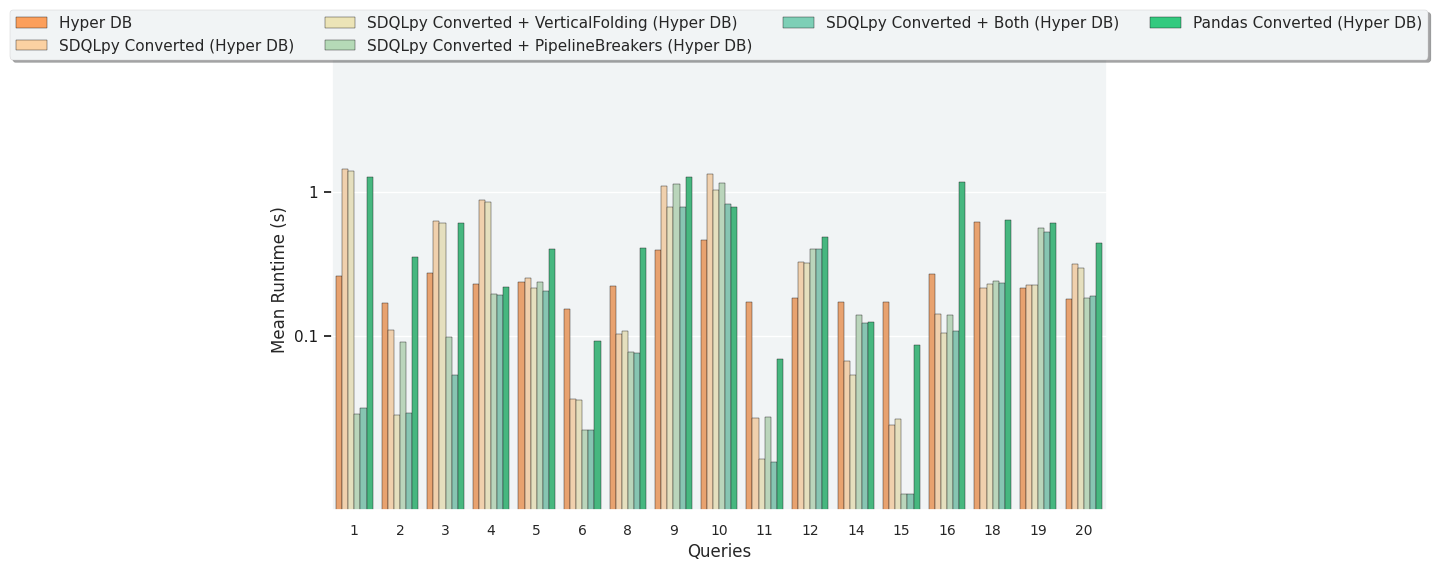

In [22]:
# All 6 Datapoints - TPC-H
all_6_order = ["Hyper DB", "SDQLpy Converted (Hyper DB)", "SDQLpy Converted + VerticalFolding (Hyper DB)",
               "SDQLpy Converted + PipelineBreakers (Hyper DB)", "SDQLpy Converted + Both (Hyper DB)",
               "Pandas Converted (Hyper DB)"]
all_6_data = results[results["Query Type"].isin(all_6_order)]

all_6_color = [DBColors.HYPER.value, DBColors.SDQLPY.value, DBColors.SDQLPY_VF.value,
               DBColors.SDQLPY_PB.value, DBColors.SDQLPY_BOTH.value, DBColors.PANDAS.value]
print(all_6_color)
all_6_hatch = [None, None, None, None, None, None]
all_6_filename = None

make_compare_graph(all_6_data, 
                   all_6_order,
                   all_6_color,
                   all_6_hatch,
                   all_6_filename)

The DataFrame has 51 rows


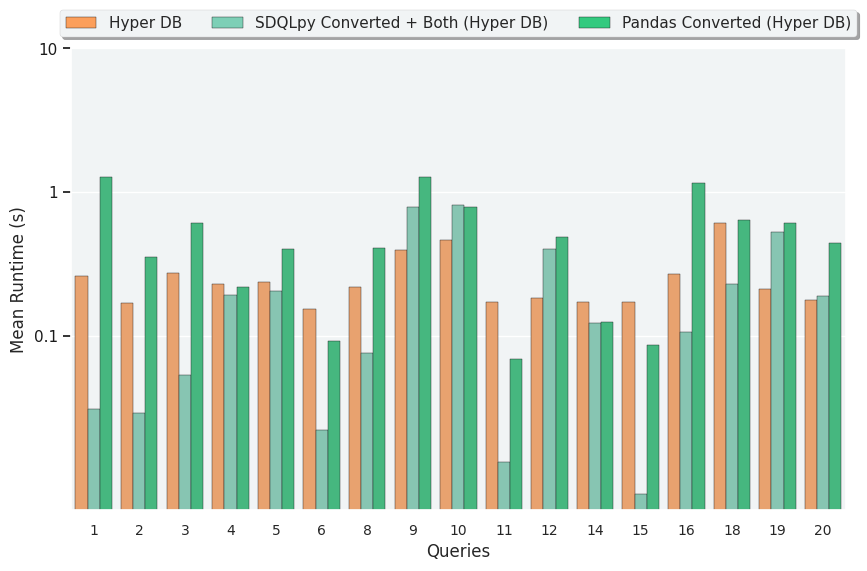

In [23]:
#  Hyper VS Pandas (Hyper) VS SDQLpy Converted + Both (Hyper) - TPC-H
hyper_vs_pd_vs_sdqlpy_best_order = ["Hyper DB", "SDQLpy Converted + Both (Hyper DB)",
               "Pandas Converted (Hyper DB)"]
hyper_vs_pd_vs_sdqlpy_best_data = results[results["Query Type"].isin(hyper_vs_pd_vs_sdqlpy_best_order)]

hyper_vs_pd_vs_sdqlpy_best_color = [DBColors.HYPER.value, DBColors.SDQLPY_BOTH.value, DBColors.PANDAS.value]
hyper_vs_pd_vs_sdqlpy_best_hatch = [None, None, None]
hyper_vs_pd_vs_sdqlpy_best_filename = None

make_compare_graph(hyper_vs_pd_vs_sdqlpy_best_data, 
                   hyper_vs_pd_vs_sdqlpy_best_order,
                   hyper_vs_pd_vs_sdqlpy_best_color,
                   hyper_vs_pd_vs_sdqlpy_best_hatch,
                   hyper_vs_pd_vs_sdqlpy_best_filename)

The DataFrame has 34 rows


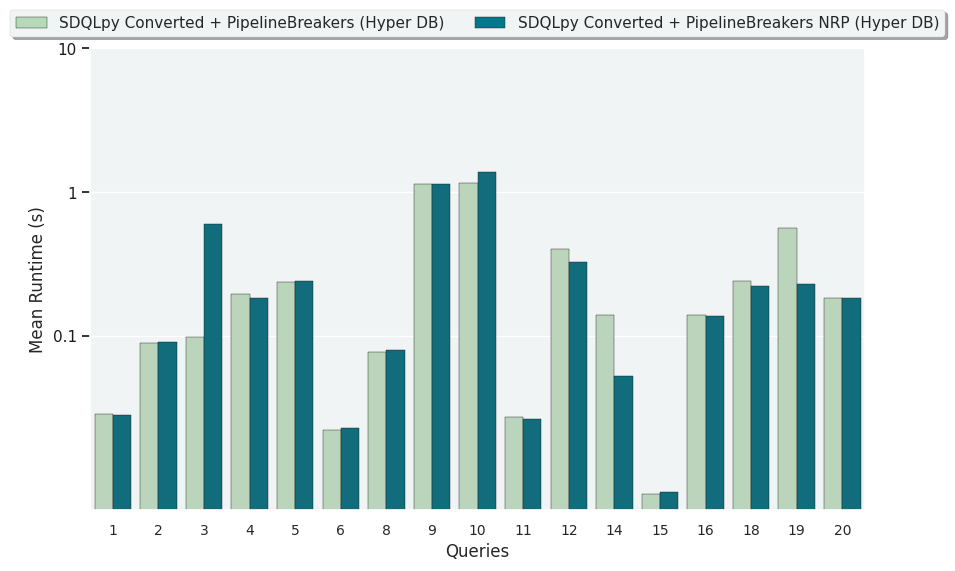

In [24]:
# SDQLpy Converted (Hyper) VS SDQLpy Converted + VerticalFolding (Hyper) VS SDQLpy Converted + PipelineBreakers (Hyper) VS SDQLpy Converted + Both (Hyper) - TPC-H
sdqlpy_versions_order = [#"SDQLpy Converted (Hyper DB)", "SDQLpy Converted + VerticalFolding (Hyper DB)",
                                    "SDQLpy Converted + PipelineBreakers (Hyper DB)", "SDQLpy Converted + PipelineBreakers NRP (Hyper DB)"] # ,
                                    #"SDQLpy Converted + Both (Hyper DB)", "SDQLpy Converted + Both V2 (Hyper DB)"]
sdqlpy_versions_data = results[results["Query Type"].isin(sdqlpy_versions_order)]

sdqlpy_versions_color = [#DBColors.SDQLPY.value, DBColors.SDQLPY_VF.value,
                         DBColors.SDQLPY_PB.value, DBColors.SDQLPY_PB_NRP.value] # ,
                         #DBColors.SDQLPY_BOTH.value, DBColors.SDQLPY_BOTH_V2.value]
sdqlpy_versions_hatch = [None, None] #, None, None, None, None]
sdqlpy_versions_filename = None

make_compare_graph(sdqlpy_versions_data, 
                   sdqlpy_versions_order,
                   sdqlpy_versions_color,
                   sdqlpy_versions_hatch,
                   sdqlpy_versions_filename)

In [ ]:
sdqlpy_versions_data

,Query Type,Query Number,Mean,Runs
102,SDQLpy Converted + PipelineBreakers V2 (Hyper DB),1,0.028420,"[0.030429840087890625, 0.026937007904052734, 0..."
3,SDQLpy Converted + PipelineBreakers (Hyper DB),1,0.028561,"[0.03010869026184082, 0.027549028396606445, 0...."
104,SDQLpy Converted + PipelineBreakers V2 (Hyper DB),2,0.091120,"[0.11130428314208984, 0.10268926620483398, 0.0..."
9,SDQLpy Converted + PipelineBreakers (Hyper DB),2,0.090208,"[0.10983753204345703, 0.10058736801147461, 0.0..."
15,SDQLpy Converted + PipelineBreakers (Hyper DB),3,0.098106,"[0.10097599029541016, 0.09600162506103516, 0.0..."
106,SDQLpy Converted + PipelineBreakers V2 (Hyper DB),3,0.599094,"[0.6292223930358887, 0.590289831161499, 0.6022..."
108,SDQLpy Converted + PipelineBreakers V2 (Hyper DB),4,0.183634,"[0.207200288772583, 0.18627095222473145, 0.182..."
21,SDQLpy Converted + PipelineBreakers (Hyper DB),4,0.196405,"[0.2217574119567871, 0.19818902015686035, 0.19..."
27,SDQLpy Converted + PipelineBreakers (Hyper DB),5,0.235882,"[0.25458383560180664, 0.23117661476135254, 0.2..."
110,SDQLpy Converted + PipelineBreakers V2 (Hyper DB),5,0.242166,"[0.26324987411499023, 0.2424333095550537, 0.23..."


,Query Type,Query Number,Mean,Runs
3,SDQLpy Converted + PipelineBreakers (Hyper DB),1,0.028561,"[0.03010869026184082, 0.027549028396606445, 0...."
9,SDQLpy Converted + PipelineBreakers (Hyper DB),2,0.090208,"[0.10983753204345703, 0.10058736801147461, 0.0..."
15,SDQLpy Converted + PipelineBreakers (Hyper DB),3,0.098106,"[0.10097599029541016, 0.09600162506103516, 0.0..."
21,SDQLpy Converted + PipelineBreakers (Hyper DB),4,0.196405,"[0.2217574119567871, 0.19818902015686035, 0.19..."
27,SDQLpy Converted + PipelineBreakers (Hyper DB),5,0.235882,"[0.25458383560180664, 0.23117661476135254, 0.2..."
33,SDQLpy Converted + PipelineBreakers (Hyper DB),6,0.022262,"[0.024982929229736328, 0.022248029708862305, 0..."
39,SDQLpy Converted + PipelineBreakers (Hyper DB),8,0.076994,"[0.09223747253417969, 0.07473540306091309, 0.0..."
45,SDQLpy Converted + PipelineBreakers (Hyper DB),9,1.134339,"[1.1591289043426514, 1.1271653175354004, 1.156..."
51,SDQLpy Converted + PipelineBreakers (Hyper DB),10,1.156540,"[1.2309916019439697, 1.1503393650054932, 1.158..."
57,SDQLpy Converted + PipelineBreakers (Hyper DB),11,0.027317,"[0.0394139289855957, 0.026584386825561523, 0.0..."


In [ ]:
# We are carrying a filter from the right side up into the join
# This is instead of creating another summation, can we use some heuristics to determine whether it's worth doing
# As sometimes, moving it is quicker - but sometimes, leaving it is quicker Q3 vs Q19

## Statistics

In [ ]:
overall = results.groupby("Query Type").agg(
    overall_mean_runtime=("Mean", "mean")
)
overall = overall.sort_values(by="overall_mean_runtime")
overall = overall.rename(columns={"overall_mean_runtime": "Overall Mean Runtime (s)"})

overall.head(7)

,Overall Mean Runtime (s)
Query Type,
SDQLpy Converted + Both (Hyper DB),0.224466
SDQLpy Converted + Both V2 (Hyper DB),0.244062
Hyper DB,0.258313
SDQLpy Converted + PipelineBreakers (Hyper DB),0.278801
SDQLpy Converted + PipelineBreakers V2 (Hyper DB),0.292820
SDQLpy Converted + VerticalFolding (Hyper DB),0.372226
SDQLpy Converted (Hyper DB),0.424921


The DataFrame has 6 rows


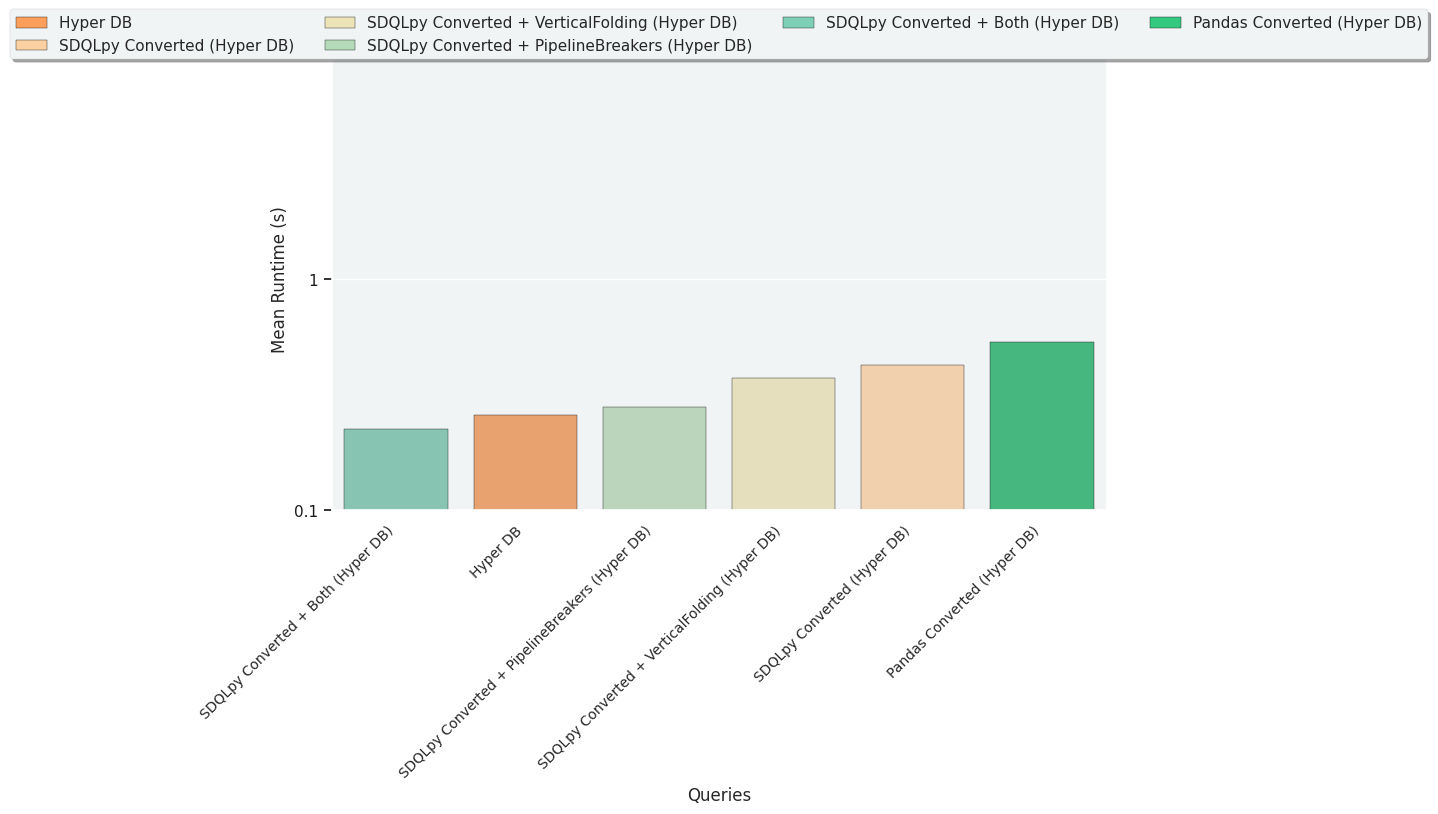

In [ ]:
# Average runtime chart

# Hyper VS Pandas (Hyper) - TPC-H
hyper_order = ["Hyper DB", "SDQLpy Converted (Hyper DB)", "SDQLpy Converted + VerticalFolding (Hyper DB)",
               "SDQLpy Converted + PipelineBreakers (Hyper DB)", "SDQLpy Converted + Both (Hyper DB)",
               "Pandas Converted (Hyper DB)"]
hyper_color = [DBColors.HYPER.value, DBColors.SDQLPY.value, DBColors.SDQLPY_VF.value,
               DBColors.SDQLPY_PB.value, DBColors.SDQLPY_BOTH.value, DBColors.PANDAS.value]
hyper_hatch = [None, None, None, None, None, None]
hyper_filename = None

make_average_graph(overall, 
                   hyper_order,
                   hyper_color,
                   hyper_hatch,
                   hyper_filename, "Query Type", "Overall Mean Runtime (s)")